In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [51]:
df = pd.read_parquet('Data\process_taxis.parquet',engine='pyarrow',
                     columns=['pickup_datetime','passenger_count','trip_distance','total_price',
                              'service','fuel_type','maintenance','energy_consumption',
                              'fuel_cost','net_profit','trip_duration','labor','co2'])

In [23]:
#df = df.sample(100000)

In [24]:
df.tail(3)

,pickup_datetime,passenger_count,trip_distance,total_price,service,fuel_type,maintenance,energy_consumption,fuel_cost,net_profit,trip_duration,labor,co2
24456612,2023-09-01 08:24:06,6,4.480,30.38,0,1,0.336,0.1120,0.103040,26.124016,0.293611,3.816944,0.0000
24296677,2023-08-31 06:56:53,5,3.104,20.10,0,0,0.776,0.3104,0.285568,16.694821,0.180278,2.343611,8.0704
3903094,2023-02-10 14:02:16,1,4.384,15.70,0,0,1.096,0.4384,0.403328,11.831783,0.182222,2.368889,11.3984


Procederemos a calcular la media y la desviación estándar de las columnas: trip_distance, total_price y trip_duration. Utilizando la regla empírica (que establece que aproximadamente el 99.7% de los datos se encuentran dentro de 3 desviaciones estándar de la media) para filtrar los valores que se encuentran dentro de este rango. De esta manera, se eliminan los valores atípicos que podrían afectar negativamente el análisis de datos y el entrenamiento de modelos de machine learning.

In [25]:
print(df['trip_distance'].mean())
print(df['total_price'].mean())
print(df['trip_duration'].mean())
df.shape

3.13955376
24.0174806
0.21466219444444445


(100000, 13)

In [26]:
# Calcular la media y desviación estándar para cada columna
mean_trip_distance = df['trip_distance'].mean()
std_trip_distance = df['trip_distance'].std()

mean_total_price = df['total_price'].mean()
std_total_price = df['total_price'].std()

mean_trip_duration = df['trip_duration'].mean()
std_trip_duration = df['trip_duration'].std()

# Filtrar valores dentro de 3 desviaciones estándar para cada columna
df_withoutliers = df[
    (df['trip_distance'] >= mean_trip_distance - 3 * std_trip_distance) & 
    (df['trip_distance'] <= mean_trip_distance + 3 * std_trip_distance) &
    (df['total_price'] >= mean_total_price - 3 * std_total_price) & 
    (df['total_price'] <= mean_total_price + 3 * std_total_price) &
    (df['trip_duration'] >= mean_trip_duration - 3 * std_trip_duration) & 
    (df['trip_duration'] <= mean_trip_duration + 3 * std_trip_duration)
]

In [27]:
print(df_withoutliers['trip_distance'].mean())
print(df_withoutliers['total_price'].mean())
print(df_withoutliers['trip_duration'].mean())
print(df_withoutliers.shape)

2.908870284237726
23.05502356589147
0.20418687051392476
(96750, 13)


Eliminamos las columnas con datos negativos en el precio total y la duracion del viaje.

In [28]:
df_withoutliers = df_withoutliers[df_withoutliers['total_price'] >= 0]
df_withoutliers = df_withoutliers[df_withoutliers['trip_duration'] >= 0]

## 1.0: Distribution

Text(0.5, 1.0, 'trip_duration')

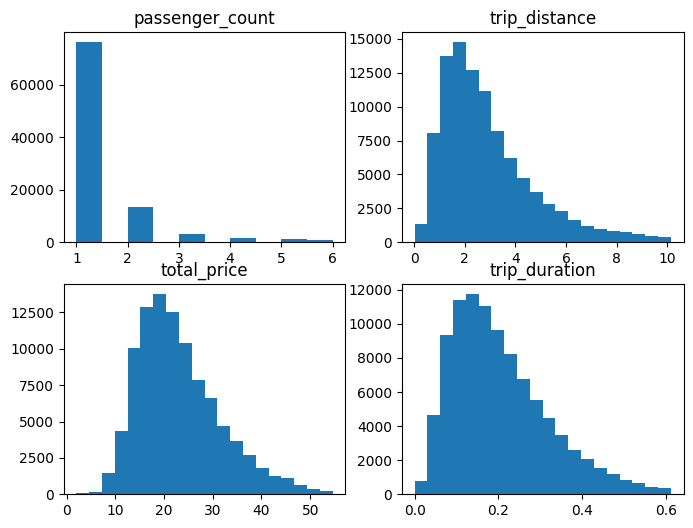

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
axs[0,0].hist(df_withoutliers['passenger_count'])
axs[0,0].set_title('passenger_count')
axs[0,1].hist(df_withoutliers['trip_distance'], bins=20)
axs[0,1].set_title('trip_distance')
axs[1,0].hist(df_withoutliers['total_price'], bins=20)
axs[1,0].set_title('total_price')
axs[1,1].hist(df_withoutliers['trip_duration'], bins=20)
axs[1,1].set_title('trip_duration')


- Cantidad de Pasajeros (passenger_count):

La mayoría de los viajes realizados en taxis o servicios de viajes compartidos en Nueva York involucran a un solo pasajero, como se observa en la marcada concentración hacia los valores más bajos en el histograma.
La demanda parece inclinarse hacia autos compactos, capaces de transportar de manera eficiente a un solo pasajero o parejas. Sin embargo, podría haber oportunidades en zonas específicas o durante eventos donde los viajes grupales puedan aumentar, lo que justificaría tener algunos vehículos más grandes disponibles.

- Distancia de Viaje (trip_distance):

La distancia promedio de los viajes tiende a ser corta, con la mayoría de los viajes ubicados por debajo de las 5 millas. Solo una minoría de viajes excede esta distancia, lo que puede reflejar la naturaleza intrínseca de la movilidad urbana, donde los viajes son mayormente locales y los usuarios optan por el taxi para trayectos cortos y rápidos.


- Tiempo del Viaje (trip_duration):

La duración de los viajes sigue una distribución similar a la distancia, con la mayoría de los trayectos durando menos de 15 minutos. Esto refleja la eficiencia de los servicios en la ciudad, donde las personas prefieren utilizar taxis para movimientos rápidos dentro de Manhattan o sus alrededores. La cola larga de la distribución sugiere la presencia de algunos viajes considerablemente más largos, posiblemente debido a factores como el tráfico o la distancia, especialmente en trayectos fuera del centro urbano.
Estos datos sobre la duración del viaje pueden ayudar a la empresa a planificar mejor los turnos de los conductores y la rotación de vehículos, así como a prever los períodos de inactividad entre los viajes.

- Precio Total (total_price):

La distribución del precio total muestra una mayoría de viajes con un costo moderado, entre $10 y $30. No obstante, algunos viajes alcanzan tarifas considerablemente más altas, lo que podría correlacionarse con viajes más largos o en horarios de alta demanda. La relación entre distancia y precio es predecible, aunque también podría haber fluctuaciones debido a factores como tarifas dinámicas o tiempos prolongados debido a congestiones de tráfico.

In [30]:
df_withoutliers.columns

Index(['pickup_datetime', 'passenger_count', 'trip_distance', 'total_price',
       'service', 'fuel_type', 'maintenance', 'energy_consumption',
       'fuel_cost', 'net_profit', 'trip_duration', 'labor', 'co2'],
      dtype='object')

Text(0.5, 1.0, 'co2')

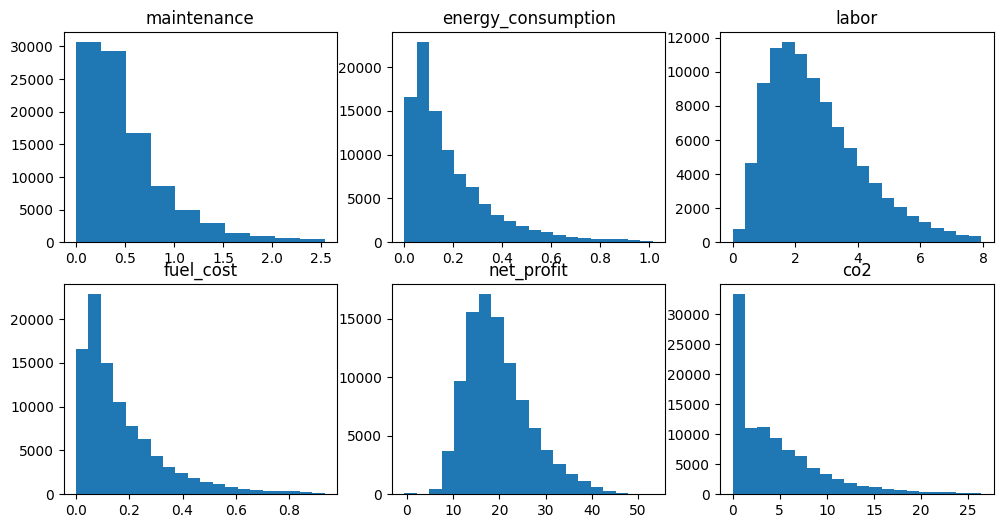

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
axs[0,0].hist(df_withoutliers['maintenance'])
axs[0,0].set_title('maintenance')
axs[0,1].hist(df_withoutliers['energy_consumption'], bins=20)
axs[0,1].set_title('energy_consumption')
axs[1,0].hist(df_withoutliers['fuel_cost'], bins=20)
axs[1,0].set_title('fuel_cost')
axs[1,1].hist(df_withoutliers['net_profit'], bins=20)
axs[1,1].set_title('net_profit')
axs[0,2].hist(df_withoutliers['labor'], bins=20)
axs[0,2].set_title('labor')
axs[1,2].hist(df_withoutliers['co2'], bins=20)
axs[1,2].set_title('co2')

- Mantenimiento y Consumo de Energía: Ambas variables parecen tener una distribución sesgada hacia la derecha y considerar que la mayoría de los taxis tienen costos de mantenimiento y consumo de energía relativamente bajos, pero hay un número menor de taxis con costos mucho más altos.

- Mano de Obra: La distribución de la mano de obra parece más normal, con una concentración en un rango de valores medio.

- Costo de Combustible: Similar al mantenimiento y consumo de energía, la distribución está sesgada hacia la derecha.

- Ganancia Neta: La distribución de la ganancia neta también está sesgada hacia la derecha, lo que indica que la mayoría de los taxis tienen ganancias relativamente bajas.

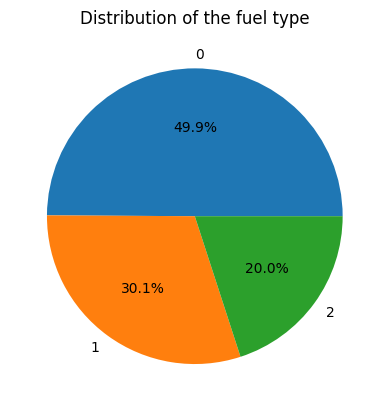

In [32]:
counts = df_withoutliers['fuel_type'].value_counts()
plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
plt.title('Distribution of the fuel type')
plt.show()


Existe un claro desbalanceo de clases entre los taxis que realizan viajes por fuera del distrito de Manhattan, lo que podria llegar a complicar a la hora de predecir la cantidad de viajes intra e inter distrito.

## 1.1 Correlation


In [33]:
df_withoutliers.columns

Index(['pickup_datetime', 'passenger_count', 'trip_distance', 'total_price',
       'service', 'fuel_type', 'maintenance', 'energy_consumption',
       'fuel_cost', 'net_profit', 'trip_duration', 'labor', 'co2'],
      dtype='object')

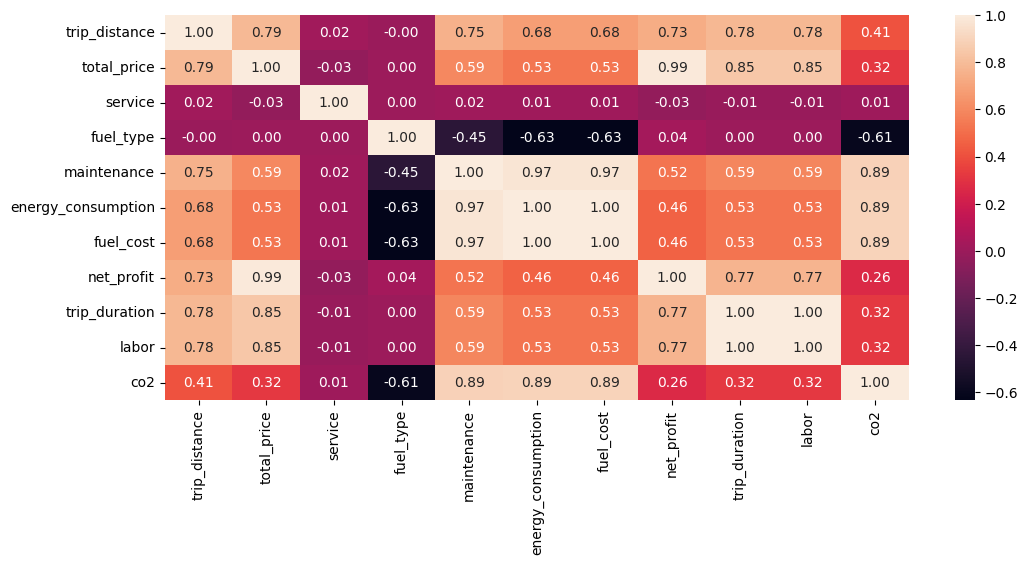

In [34]:
corr = df_withoutliers[['trip_distance', 'total_price',
       'service', 'fuel_type', 'maintenance', 'energy_consumption',
       'fuel_cost', 'net_profit', 'trip_duration', 'labor','co2']].corr(method='spearman')
plt.figure(figsize=(12,5))
sns.heatmap(data=corr,annot=True,fmt='.2f')
plt.show()

In [35]:
df_withoutliers.head(3)

,pickup_datetime,passenger_count,trip_distance,total_price,service,fuel_type,maintenance,energy_consumption,fuel_cost,net_profit,trip_duration,labor,co2
41925174,2024-02-23 08:08:37,1,2.240,17.00,0,2,0.336,0.0784,0.072128,14.627428,0.151111,1.964444,2.2176
35942244,2023-12-20 17:53:38,1,3.680,33.10,0,2,0.552,0.1288,0.118496,29.316726,0.239444,3.112778,3.6432
10526566,2023-04-15 03:04:52,6,3.008,21.98,0,0,0.752,0.3008,0.276736,19.261264,0.130000,1.690000,7.8208


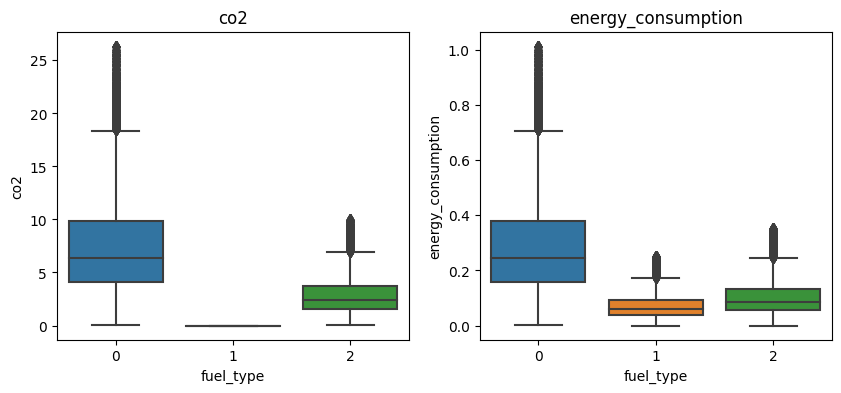

In [36]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.boxplot(ax=axs[0],x='fuel_type',y='co2',data= df_withoutliers)
axs[0].set_title('co2')
sns.boxplot(ax=axs[1],x='fuel_type',y='energy_consumption',data= df_withoutliers)
axs[1].set_title('energy_consumption')
plt.show()

El análisis de los datos revela una clara influencia del tipo de combustible en las emisiones de CO2 y el consumo de energía de los taxis. Los vehículos de combustión interna (tipo 0) presentan los valores más altos y una mayor variabilidad en ambos indicadores, seguidos por los híbridos (tipo 2) y los eléctricos  (tipo 1). 

Esta tendencia sugiere que los vehículos eléctricos son los más eficientes, mientras que los de combustión interna son los menos eficientes. Sin embargo, es importante destacar la presencia de valores atípicos, especialmente en las emisiones de CO2, que podrían distorsionar ligeramente los resultados. 

Además, la distribución asimétrica de los datos indica que hay vehículos que se desvían significativamente de los valores promedio, lo cual podría atribuirse a factores como la edad del vehículo, el modelo, el tamaño del motor o las condiciones de conducción, entre otros.

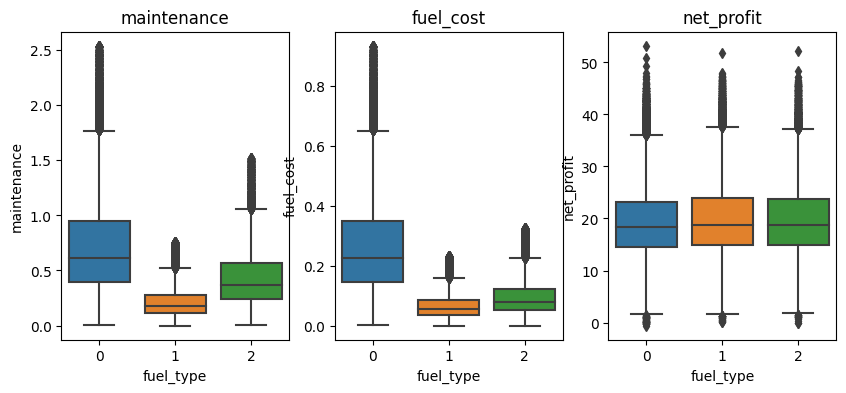

In [37]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4))
sns.boxplot(ax=axs[0],x='fuel_type',y='maintenance',data= df_withoutliers)
axs[0].set_title('maintenance')
sns.boxplot(ax=axs[1],x='fuel_type',y='fuel_cost',data= df_withoutliers)
axs[1].set_title('fuel_cost')
sns.boxplot(ax=axs[2],x='fuel_type',y='net_profit',data= df_withoutliers)
axs[2].set_title('net_profit')
plt.show()

Podemos observar que se muestra que existe una variabilidad en los costos de mantenimiento y combustible, así como en las ganancias netas, según el tipo de combustible utilizado. Los boxplots revelan que, en general, los vehiculos de combustion interna(tipo 0) tienden a tener costos de mantenimiento ligeramente superiores en comparación con los otros tipos.

En cuanto al costo de combustible, también se observa una tendencia similar, sin embargo, es interesante notar que las ganancias netas parecen ser relativamente similares entre los diferentes tipos de combustible, a pesar de las variaciones en los costos.

In [38]:
# Agrupar por categoría y calcular la media
grouped = df.groupby('fuel_type')['net_profit'].mean()
print(grouped)

fuel_type
0    20.182826
1    20.812022
2    20.735012
Name: net_profit, dtype: float64


## 1.2 Time Series

In [39]:
from funciones import time_series

In [52]:
df['year'] = df['pickup_datetime'].dt.year
df['quarter'] = df['pickup_datetime'].dt.quarter
df['month'] = df['pickup_datetime'].dt.month
df['day_month'] = df['pickup_datetime'].dt.day
df['weekday'] = df['pickup_datetime'].dt.day_name()
df['hour'] = df['pickup_datetime'].dt.hour
df['weekend'] = df['pickup_datetime'].apply(lambda x: x.weekday() < 5).astype(int) # 1 = weekday, 0 = weekend
#df.drop(columns=['pickup_datetime','dropoff_datetime'],inplace=True)

In [41]:
df.columns

Index(['pickup_datetime', 'passenger_count', 'trip_distance', 'total_price',
       'service', 'fuel_type', 'maintenance', 'energy_consumption',
       'fuel_cost', 'net_profit', 'trip_duration', 'labor', 'co2', 'year',
       'quarter', 'month', 'day_month', 'weekday', 'hour', 'weekend'],
      dtype='object')

Usaremos solamente el año 2023 debido a que el año 2024 todavia no se encuentran todos los datos disponibles.

Considerar que los cuartos corresponden con:

- Invierno: Primer trimestre (Comienza el 21 de diciembre y termina el 20 de marzo.)
- Primavera: Segundo trimestre (Comienza alrededor del 20 de marzo y termina el 21 de junio.)
- Verano: Tercer trimestre (Inicia el 21 de junio y finaliza el 22 de septiembre.)
- Otoño: Cuarto trimestre (Empieza el 22 de septiembre y concluye el 21 de diciembre.)

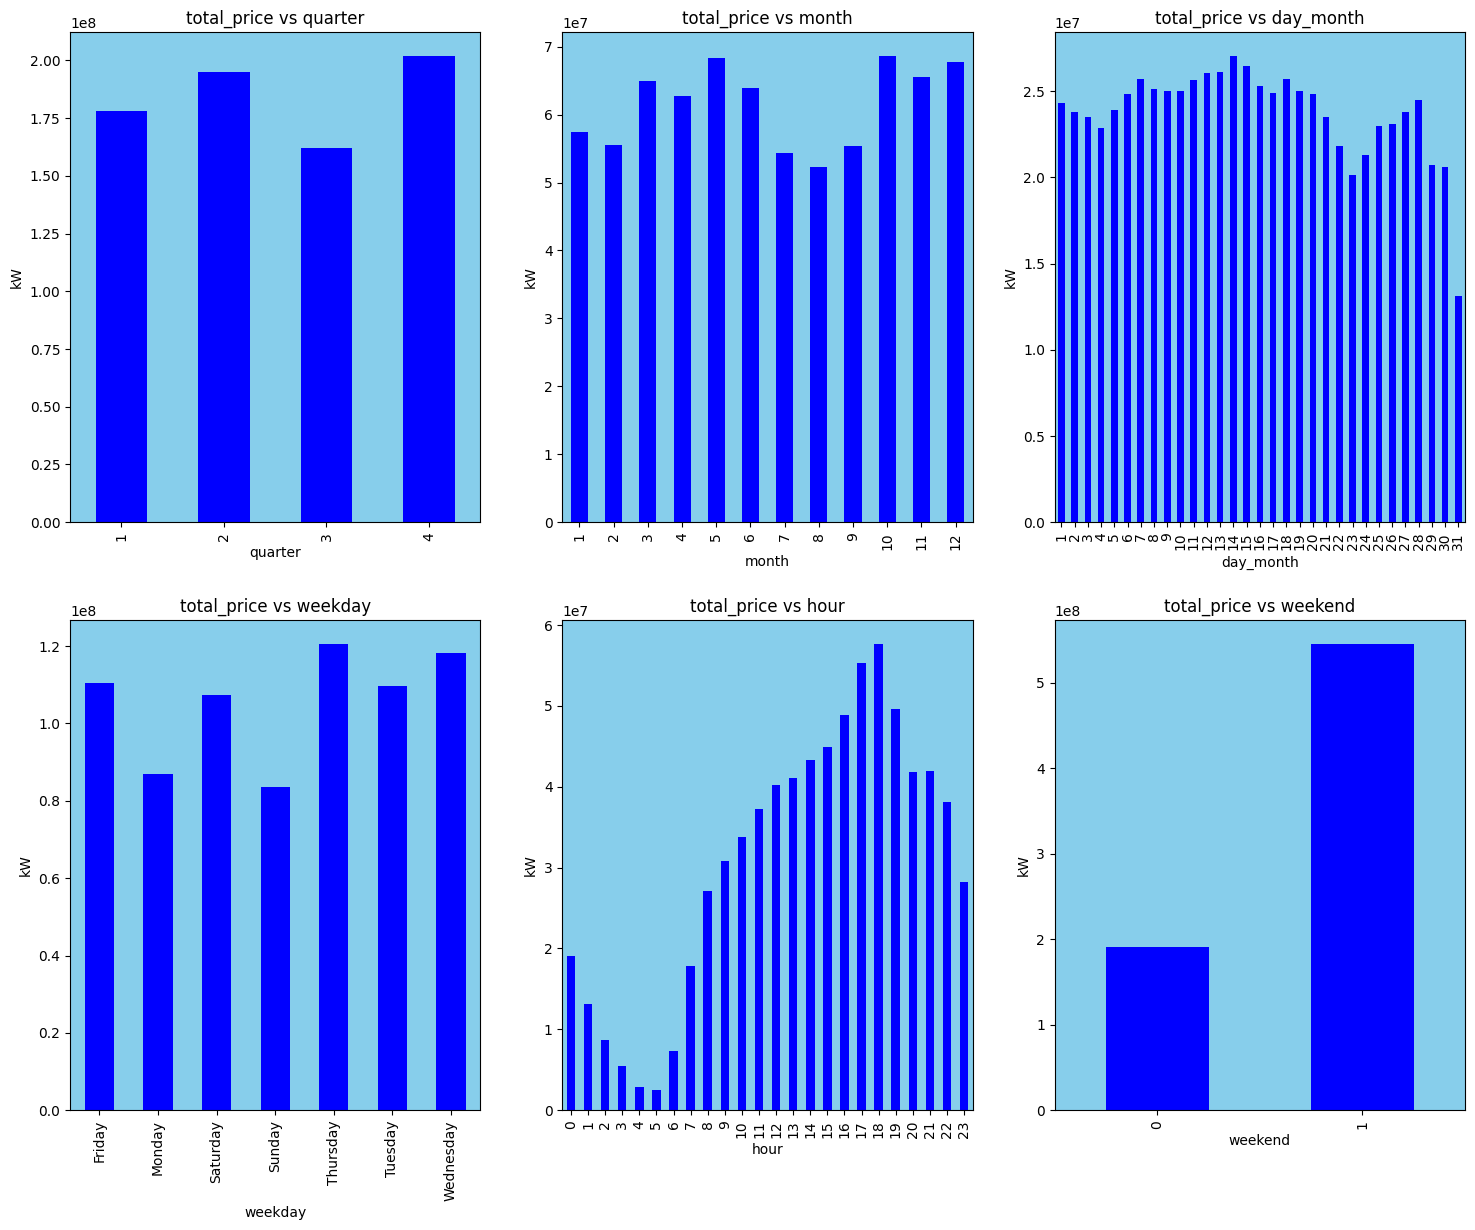

In [57]:
temporalidades = ['quarter','month','day_month','weekday','hour','weekend']
time_series(df[df['year']==2023],'total_price',temporalidades=temporalidades)

In [58]:
print(df['weekend'].value_counts()[0]/df.shape[0])
print(df['weekend'].value_counts()[1]/df.shape[0])
print(2/7)
print(5/7)

0.2715608063170903
0.7284391936829097
0.2857142857142857
0.7142857142857143


Respecto a los fines de semana, si podemos decir que los sabados y domingos son dias de mucha demanda pero no se alejan significativamente del promedio de los demas dias.

Podemos analizar acerca de los trimestres y es que los 2 trimestres con mayor frecuencia de viajes es el cuarto(otoño) y el segundo(primavera) y el de menor frecuencia es el tercero(verano).

Respecto al mes podemos ver que existen ciertas tendencias pero no son tan claras, lo que si podemos inferir es que durante los meses 7,8 y 9 existe una manero demanda aunque tampoco es tan significativa. Estos meses concuerdan con nuestro analisis sobre los trimestres debido a que se encuentran en verano.

Al comenzar el jueves, existe una demanda significativa hasta el domingo, siendo estos los dias de mayor frecuencia tiempo donde mas se mantienene las demandas de los viajes.

Podemos observar que durante el comienzo del horario laboral habitual(7-8 am en adelante) existe un constante aumento en la demanda hasta un pico en las 18 horas. Durante la noche disminuye significativamente la demanda.


### Conclusiones:

Se ha identificado una demanda mayoritaria de viajes con un solo pasajero y trayectos cortos (menos de 5 millas y menos de 15 minutos de duración). Esto sugiere que la flota ideal debería incluir vehículos compactos, posiblemente con una menor proporción de vehículos más grandes, reservados para momentos o zonas específicas con alta demanda de viajes grupales.

Los vehículos eléctricos son los más eficientes en consumo de energía y emisión de CO2, en comparación con los vehículos de combustión interna y los híbridos. Los valores atípicos en las emisiones de CO2 destacan la influencia de factores adicionales como el tipo y la antigüedad del vehículo. Sin embargo, se observa que el mantenimiento y el combustible tienen una variabilidad significativa, lo que podría ser útil en la planificación de costos y rotación de la flota.

Las conclusiones del analisis reflejan patrones semanales (jueves a domingo), horarios (pico a las 18 horas), y estacionales (alta demanda en primavera y otoño, menor en verano). Esto proporciona una base para ajustar la disponibilidad de la flota según la hora y la época del año.
